<a href="https://colab.research.google.com/github/Niccolo-Rocchi/Medical_Imaging_project/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
%%capture 
!pip install pydicom

In [2]:
# For reading files
from pydicom import dcmread 
import glob
from google.colab import drive
# For dealing with data
import numpy as np
import pandas as pd
import re
import random
random.seed(123)
# For plots
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
# For nets
import tensorflow as tf
from skimage.transform import resize
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate as concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

In [3]:
# Mount Drive data
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/pneumotorax_data

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/DS Lab in Medicine - projects/Medical Imaging - project/pneumotorax_data


## Data upload

In [4]:
# Read patients IDs and their encoded pixels
encoded_pixels = pd.read_csv('./encoded_pixels.csv')
# Read dicom files IDs
dicom_files_IDs = glob.glob('./dicom_files/*')
dicom_files_IDs = pd.DataFrame({"dicom_ID" : [re.findall(r"\./dicom_files/(.+)\.dcm", id)[0] for id in dicom_files_IDs]})
# Intersect patients IDs with dicom IDs
encoded_pixels = pd.merge(encoded_pixels, dicom_files_IDs, how = "inner", left_on = "ImageId", right_on = "dicom_ID")
# Mark healthy patients as "0"
encoded_pixels[" EncodedPixels"] = encoded_pixels[" EncodedPixels"].apply(lambda x: x.split())
encoded_pixels["Health"] = encoded_pixels[" EncodedPixels"].apply(lambda x: 0 if len(x)==1 else 1)

In [5]:
# Find by how many pts healthy vs unhealthy the dataset differ
diff = len(encoded_pixels[encoded_pixels["Health"] == 0]) - len(encoded_pixels[encoded_pixels["Health"] == 1])
# Select this number of pts in a random manner and drop them in the dataset
healthy_idx = list(encoded_pixels[encoded_pixels["Health"] == 0].index)
random.shuffle(healthy_idx)
encoded_pixels.drop(index = healthy_idx[:diff], inplace = True)
# Assert
assert(len(encoded_pixels[encoded_pixels["Health"] == 0]) == len(encoded_pixels[encoded_pixels["Health"] == 1]))

In [6]:
# Reset indices
encoded_pixels.reset_index(drop = True, inplace = True)
# Sample the dataset
train_frac = 0.8
train_set = encoded_pixels.sample(frac = train_frac, random_state = 123)
val_set = encoded_pixels.drop(index = train_set.index).sample(frac = 1, random_state = 1)
# Assert there's no intersection between two sets
assert([i for i in val_set.index if i in train_set.index] == [])
# Make size compatible with batches
max_batch_size = 32
train_set = train_set.iloc[:-(len(train_set)%max_batch_size)]
val_set = val_set.iloc[:-(len(val_set)%max_batch_size)]
# Reset indices
train_set.reset_index(drop = True, inplace = True)
val_set.reset_index(drop = True, inplace = True)

In [7]:
# RLE to mask conversion provided by competition organizers with the dataset.
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    if rle == ['-1']:
      return mask.reshape(width, height, order='F')
    else:
      for index, start in enumerate(starts):
          current_position += start
          mask[current_position:current_position+lengths[index]] = 255
          current_position += lengths[index]
      return mask.reshape(width, height, order='F')

In [8]:
# Create input for Keras' fit function
class DataGenerator:

  # Method that yields (image, mask) tuple
  def data_generator(self, data):
    while True:
      i = 0
      while i < len(data):
        # Extract ID and its encoded pixels
        id, rle = data[["ImageId"," EncodedPixels"]].iloc[i]
        # Convert encoded pixels to mask
        mask = rle2mask(rle, 1024, 1024)
        # Read the image associate to ImageId
        try:
          dcm_file = dcmread(f"./dicom_files/{id}.dcm")
        except:
          continue
        dcm_image = dcm_file.pixel_array
        # Rescale image
        image = dcm_image/255
        # Expand dimensions
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        # Resize image and mask
        mask = tf.keras.layers.Resizing(256, 256, interpolation="nearest", crop_to_aspect_ratio=False)(mask)
        image = tf.keras.layers.Resizing(256, 256, interpolation="bilinear", crop_to_aspect_ratio=False)(image)
        yield (image, mask)
        i += 1

  # Create train generator for net input
  def train_generator(self, batch_size):
    # Create a tensorflow iterator
    tf_iterator = tf.data.Dataset.from_generator(lambda: self.data_generator(train_set), output_types=(tf.float64, tf.float64))
    # Create batch size
    tf_iterator = tf_iterator.batch(batch_size)
    # Return generator
    return tf_iterator

  # Create validation generator for net input
  def val_generator(self, batch_size):
    # Create a tensorflow iterator
    tf_iterator = tf.data.Dataset.from_generator(lambda: self.data_generator(val_set), output_types=(tf.float64, tf.float64))
    # Create batch size
    tf_iterator = tf_iterator.batch(batch_size)
    # Return generator
    return tf_iterator

## U-net

### Loss functions

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

### Net definition and train

In [10]:
# Loss
loss = focal_loss()

# Batch and epochs
batch_size = 32
epochs = 20
assert(batch_size <= max_batch_size)

# Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) 

In [11]:
# Net
def create_model(loss):

  # Model description
  inputs = Input((256, 256, 1))

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate()([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate()([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate()([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate(axis=3)([u9, c1])
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  # Model compilation
  model.compile(optimizer='adam', loss=loss, metrics=[dice_p_bce])

  # Return model
  return model

In [12]:
# Net input generator
train_generator = DataGenerator().train_generator(batch_size)
val_generator = DataGenerator().val_generator(batch_size)

In [13]:
# Create model
model = create_model(loss)

# Model fit
model_history = model.fit(x = train_generator, 
                          epochs = epochs, 
                          steps_per_epoch=(len(train_set)//batch_size),
                          validation_data = val_generator,
                          validation_steps = (len(val_set)//batch_size),
                          callbacks = callback, 
                          )

Epoch 1/20
164/164 [==============================] - 340s 2s/step - loss: 0.0015 - dice_p_bce: -0.2744 - val_loss: 1.2365e-13 - val_dice_p_bce: -0.3002
Epoch 2/20
164/164 [==============================] - 267s 2s/step - loss: 5.7692e-07 - dice_p_bce: -0.2946 - val_loss: 1.1712e-13 - val_dice_p_bce: -0.3002
Epoch 3/20
164/164 [==============================] - 300s 2s/step - loss: 3.0867e-07 - dice_p_bce: -0.2953 - val_loss: 7.2485e-14 - val_dice_p_bce: -0.3002
Epoch 4/20
164/164 [==============================] - 270s 2s/step - loss: 1.1944e-07 - dice_p_bce: -0.2954 - val_loss: 9.4719e-14 - val_dice_p_bce: -0.3002
Epoch 5/20
164/164 [==============================] - 288s 2s/step - loss: 1.1234e-07 - dice_p_bce: -0.2955 - val_loss: 9.4990e-14 - val_dice_p_bce: -0.3002
Epoch 6/20
164/164 [==============================] - 280s 2s/step - loss: 2.3221e-07 - dice_p_bce: -0.2953 - val_loss: 1.0359e-13 - val_dice_p_bce: -0.3002


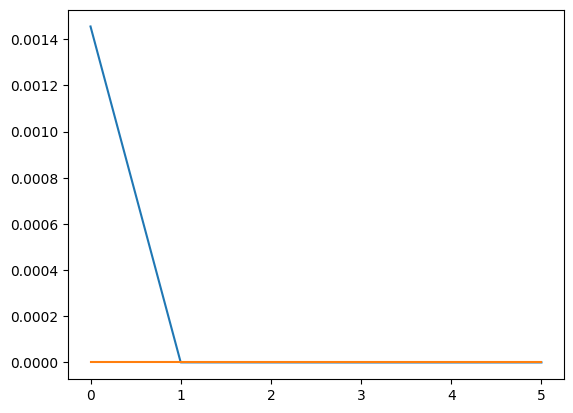

In [14]:
# Plot losses
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)

In [15]:
# Save the weights
model.save_weights(f'./trained_models/{loss}_model/{loss}')

In [16]:
# Create a new model instance
new_model = create_model(loss)

# Restore the weights
new_model.load_weights(f'./trained_models/{loss}_model/{loss}')